# Lab 3: Stochastic Gradient Descent

Welcome to the advanced Machine Learning Course.

The objective of this lab session is to code a few regression algorithms and to apply them to synthetic and real datasets.

Please put **"ML - MDS - TD3"** in the mail subject or I might lose your work (which means 0) and send it to pierre.houdouin@centralesupelec.fr

Please label your notebook **"L3_familyname1_familyname2.ipynb"** or I might lose your work (which means 0).

We begin with the standard imports:

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np
import pandas as pd
from tqdm import tqdm

We import the dataset that we are going to use, an indian dataset including in the last column information about the diabetes status of patients:

In [ ]:
from sklearn import model_selection

data = pd.read_csv("w8a.csv", sep=";", header=None)

X = data.iloc[:,:-1].to_numpy()
y = data.iloc[:,-1].to_numpy()
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.33, random_state=32)

## Logistic Regression



Today we'll be moving from linear regression to logistic regression, one of the simplest ways to deal with a classification problem. Instead of fitting a line, logistic regression models the probability that the outcome is 1 given the value of the predictor. In order to do this we need a function that transforms our predictor variable to a value between 0 and 1. Lots of functions can do that, but the logistic function is the most common choice:

$$f(z) = \frac{1}{1+\exp{-z}}.$$

To predict the class of our observations we'll have to minimize the corresponding loss function and as we are in a high-dimensional context we'll add an $l_2$ regularization to the model:

$$L(\textbf{w}) = \sum_{i=1}^n log(1+\exp(-y_i\textbf{w}^Tx_i))+\frac{\lambda}{2} \| \textbf{w} \|^2,$$

where $x_i$ is the vector of features for the observation $i$ and $y_i \in \{-1, 1\}$ is the class label.  


We first use the `sklearn` implementation:

In [ ]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(X_train,y_train)

LogisticRegression()

and we compute the accuracy score to evaluate the model performance:

In [ ]:
y_pred = model.predict(X_test)
#Here we use traditionnal accuracy computation
predicted_true = np.sum(y_pred == y_test)
predicted_false = np.sum(y_pred != y_test)
accuracy = predicted_true/(predicted_true+ predicted_false)
print(accuracy)

0.9836764526738945


In [ ]:
#Here we use the accuracy function from sklearn
from sklearn.metrics import accuracy_score
score = accuracy_score(y_test,y_pred)
score

0.9836764526738945

### Assignment

Implement from scratch your own logistic regression model with stochastic gradient descent optimization.

- Fill in the class

- Display the evolution of the cost function along iterations. Do this for several strategies for the setting of the learning rate

- Try the different acceleration strategies

- Train the model with the training set and evaluate its performance in the test set

In [ ]:
#Implementing classic SGD optimization algorithm


class StochasticLogisticRegression():

    """ Class for logistic regression:

    Attributes:
    -----------
    coef_         : 1-dimensional np.array, coefficients / weights                         | None
    lambd_        : float,                  regularization parameter                       | 0.1
    lr_           : float,                  the learning rate                              | 0.01
    bsize         : integer,                the size of the mini-batch >=1                 | 64
    gamma         : float,                  gamma coefficient                              | 0.999
    beta          : float,                  beta coefficient                               | 0.9
    eps           : float,                  epsilon coefficient                              | 10-8
    debias        : boolean,                indicates if we use the debiais correction     | False
    coef_history_ : list,                   the list of all visited betas/ weights         | []
    f_history_    : list ,                  the list of all evaluations in visited betas   | []
    thresh        : float,                  decision threshold for classification          | 0.5
    """

    def __init__(self, lambd=0.1, lr=1e-2, batchsize=64, gamma=0.999, beta=0.9, eps=1e-8, debias=False,
                 thresh=0.5):
        self.coef_         = None # weights
        self.lambd_        = lambd
        self.lr_           = lr
        self.bsize_        = batchsize
        self.gamma_        = gamma
        self.beta_         = beta
        self.eps_          = eps
        self.debias_       = debias
        self.coef_history_ = []
        self.f_history_    = []
        self.thresh_       = thresh

    def logistic(self, z):
        return 1/(1+np.exp(-z))

    def fit(self, X, y, lr=1e-2, bsize=64, max_iter=100, minibatch=False):

        """ Fit the data (X, y).

        Parameters:
        -----------
        X          : (num_samples, num_features) np.array, Design matrix                  |
        y          : (num_sampes, ) np.array,              Output vector                  |
        lr         : float,                                the learning rate              | 0.001
        bsize      : integer,                              the size of the mini-batch >=1 | 64
        max_iter   : integer,                              the number of epochs           | 100
        mini_batch : bool,                                 method used                    | False
        """
        n,p = X.shape
        X_bias = np.hstack((np.ones((n,1)),X))
        w = np.zeros(p+1)
        batch_iter = n//bsize

        for i in range(max_iter):
          idx = np.random.permutation(n)
          X_shuff = X_bias[idx]
          y_shuff = y[idx]
          for j in range(0,n,bsize):
            X_batch = X_shuff[j:j+bsize]
            y_batch = y_shuff[j:j+bsize]
            m = len(X_batch)

            loss = (1/m)*np.sum(np.log(1+np.exp(-y_batch*np.dot(X_batch,w))))
            loss += self.lambd_*np.linalg.norm(w)**2
            self.f_history_.append(loss)
            self.coef_history_.append(w)
            gradient = -np.dot(X_batch.T, y_batch * (1 - self.logistic(y_batch * np.dot(X_batch, w)))) / m
            gradient[1:] += 2 * self.lambd_ * w[1:]
            w = w - lr * gradient
        self.coef_ = w







    def predict(self, X):
      """ Make binary predictions for data X.

      Parameters:
      -----------
      X: (num_samples, num_features) np.array, Design matrix

      Returns:
      -----
      y_pred: (num_samples, ) np.array, Predictions (-1 or 1)
      """
      n, p = X.shape
      X_bias = np.hstack((np.ones((n, 1)), X))

      probabilities = self.logistic(np.dot(X_bias, self.coef_))

      y_pred = np.where(probabilities >= self.thresh_, 1, -1)

      return y_pred

    def accuracy_evaluation(self,X,y,thresh=0.5,margin=0,vizualisation=True):
        """ Compute detailed accuracy rates.

        Parameters:
        -----------                                                              Default value
        X                : (num_samples, num_features) np.array, Input data    |
        y                : (num_samples, ) np.array, Labels of the input data  |
        thresh           : Decision threshold                                  | 0.5
        margin           : If the prediction is at a distance less than margin | 0
                           to the treshold, returns undetermined label.        |
        vizualisation    : Allow the user to vizualize in a board the results  | True

        Returns:
        -----
        good_prediction  : % of correct classifications
        undetermined     : % of indetermined labels
        wrong_prediction : % of wrong classifications
        TP               : % of 1 labelled 1
        UP               : % of 1 labelled undetermined
        FN               : % of 1 labelled 0
        TN               : % of 0 labelled 0
        UN               : % of 0 labelled undetermined
        FP               : % of 0 labelled 1
        F1_score         : F1-score
        """
        y_pred = self.predict(X)

        if margin > 0:
            X_bias = np.hstack((np.ones((X.shape[0], 1)), X))
            probas = self.logistic(np.dot(X_bias, self.coef_))
            undetermined_mask = np.abs(probas - thresh) < margin
            y_pred[undetermined_mask] = 0

        n_pos = np.sum(y == 1)
        n_neg = np.sum(y == -1)

        good_prediction = np.sum(y_pred == y)/len(y)
        wrong_prediction = np.sum((y_pred != y)&(y_pred != 0))/len(y)
        undetermined = np.sum(y_pred == 0)/len(y)
        TP = np.sum((y_pred == 1) & (y == 1))/np.sum(y == 1)
        UP = np.sum((y_pred == 0) & (y == 1))/np.sum(y == 1)
        FN = np.sum((y_pred == -1) & (y == 1))/np.sum(y == 1)
        TN = np.sum((y_pred == -1) & (y == -1))/np.sum(y == -1)
        UN = np.sum((y_pred == 0) & (y == -1))/np.sum(y == -1)
        FP = np.sum((y_pred == 1) & (y == -1))/np.sum(y == -1)

        TP_count = np.sum((y_pred == 1) & (y == 1))
        FP_count = np.sum((y_pred == 1) & (y == -1))
        precision =  TP_count/ (TP_count + FP_count) if (TP_count + FP_count) > 0 else 0
        recall = TP
        F1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

        if vizualisation:
            print("--- Classification Report ---")
            print(f"Threshold: {thresh:.2f}, Margin: {margin:.2f}\n")
            print(f"Overall Accuracy : {good_prediction:.2%}")
            print(f"Wrong Predictions: {wrong_prediction:.2%}")
            print(f"Undetermined     : {undetermined:.2%}")
            print("-" * 35)
            print("Confusion Matrix Rates (as % of Actual)")
            print("                   | Pred 1 | Pred -1 | Pred Undet. |")
            print("------------------------------------------------------")
            print(f"Actual 1  ({n_pos:^5}) | {TP:^6.2%} | {FN:^7.2%} | {UP:^11.2%} |")
            print(f"Actual -1 ({n_neg:^5}) | {FP:^6.2%} | {TN:^7.2%} | {UN:^11.2%} |")
            print("------------------------------------------------------")
            print(f"Precision: {precision:.4f} | Recall: {recall:.4f} | F1-Score: {F1_score:.4f}")
            print("-" * 35)
        return {
            'good_prediction': good_prediction, 'wrong_prediction': wrong_prediction, 'undetermined': undetermined,
            'TP': TP, 'FN': FN, 'UP': UP,
            'TN': TN, 'FP': FP, 'UN': UN,
            'F1_score': F1_score
        }



    def find_thresh(self, X, y, step=0.01,margin=0):
        """Find the decision threshsold that maximize the f1_score

        Parameters:
        -----------                                                    Default value
        X      : (num_samples, num_features) np.array, Input data    |
        y      : (num_samples, ) np.array, Labels of the input data  |
        step   : Decision threshold                                  | 0.5
        margin : If the prediction is at a distance less than margin | 0
                 to the treshold, returns undetermined label.        |
        """
        best_thresh = 0.5
        best_f1 = -1

        for t in np.arange(0, 1 + step, step):
            self.thresh_ = t
            y_pred = self.predict(X)

            TP = np.sum((y_pred == 1) & (y == 1))
            FP = np.sum((y_pred == 1) & (y == 0))
            FN = np.sum((y_pred == 0) & (y == 1))

            if TP + FP == 0 or TP + FN == 0:
                continue
            precision = TP / (TP + FP)
            recall = TP / (TP + FN)
            f1 = 2 * precision * recall / (precision + recall)

            if f1 > best_f1:
                best_f1 = f1
                best_thresh = t

        self.thresh_ = best_thresh
        return best_thresh, best_f1

In [ ]:
#Implementing ADAM optimization algorithm

class StochasticLogisticRegression():

    """ Class for logistic regression:

    Attributes:
    -----------
    coef_         : 1-dimensional np.array, coefficients / weights                         | None
    lambd_        : float,                  regularization parameter                       | 0.1
    lr_           : float,                  the learning rate                              | 0.01
    bsize         : integer,                the size of the mini-batch >=1                 | 64
    gamma         : float,                  gamma coefficient                              | 0.999
    beta          : float,                  beta coefficient                               | 0.9
    eps           : float,                  epsilon coefficient                            | 10-8
    debias        : boolean,                indicates if we use the debiais correction     | False
    coef_history_ : list,                   the list of all visited betas/ weights         | []
    f_history_    : list ,                  the list of all evaluations in visited betas   | []
    thresh        : float,                  decision threshold for classification          | 0.5
    """

    def __init__(self, lambd=0.1, lr=1e-2, batchsize=64, gamma=0.999, beta=0.9, eps=1e-8, debias=False,
                 thresh=0.5):
        self.coef_         = None # weights
        self.lambd_        = lambd
        self.lr_           = lr
        self.bsize_        = batchsize
        self.gamma_        = gamma
        self.beta_         = beta
        self.eps_          = eps
        self.debias_       = debias
        self.coef_history_ = []
        self.f_history_    = []
        self.thresh_       = thresh

    def logistic(self, z):
        return 1/(1+np.exp(-z))

    def fit(self, X, y, lr=1e-2, bsize=64, max_iter=100, minibatch=False):

        """ Fit the data (X, y).

        Parameters:
        -----------
        X          : (num_samples, num_features) np.array, Design matrix                  |
        y          : (num_sampes, ) np.array,              Output vector                  |
        lr         : float,                                the learning rate              | 0.001
        bsize      : integer,                              the size of the mini-batch >=1 | 64
        max_iter   : integer,                              the number of epochs           | 100
        mini_batch : bool,                                 method used                    | False
        """
        n, p = X.shape
        X_bias = np.hstack((np.ones((n, 1)), X))
        w = np.zeros(p + 1)

        m = np.zeros(p + 1)
        v = np.zeros(p + 1)
        t = 0

        for i in range(max_iter):
            idx = np.random.permutation(n)
            X_shuff = X_bias[idx]
            y_shuff = y[idx]
            for j in range(0, n, bsize):
                X_batch = X_shuff[j:j+bsize]
                y_batch = y_shuff[j:j+bsize]
                m_batch = len(X_batch)

                t += 1

                loss = (1/m_batch)*np.sum(np.log(1+np.exp(-y_batch*np.dot(X_batch,w))))
                loss += self.lambd_*np.linalg.norm(w)**2
                self.f_history_.append(loss)
                self.coef_history_.append(w.copy())

                gradient = -np.dot(X_batch.T, y_batch * (1 - self.logistic(y_batch * np.dot(X_batch, w)))) / m_batch
                gradient[1:] += 2 * self.lambd_ * w[1:]/ m_batch


                m = self.beta_ * m + (1 - self.beta_) * gradient

                v = self.gamma_ * v + (1 - self.gamma_) * (gradient ** 2)

                m_hat = m
                v_hat = v

                if self.debias_:
                    m_hat = m / (1 - self.beta_ ** t)
                    v_hat = v / (1 - self.gamma_ ** t)

                w = w - self.lr_ * m_hat / (np.sqrt(v_hat) + self.eps_)

        self.coef_ = w







    def predict(self, X):
      """ Make binary predictions for data X.

      Parameters:
      -----------
      X: (num_samples, num_features) np.array, Design matrix

      Returns:
      -----
      y_pred: (num_samples, ) np.array, Predictions (-1 or 1)
      """
      n, p = X.shape
      X_bias = np.hstack((np.ones((n, 1)), X))

      probabilities = self.logistic(np.dot(X_bias, self.coef_))

      y_pred = np.where(probabilities >= self.thresh_, 1, -1)

      return y_pred

    def accuracy_evaluation(self,X,y,thresh=0.5,margin=0,vizualisation=True):
        """ Compute detailed accuracy rates.

        Parameters:
        -----------                                                              Default value
        X                : (num_samples, num_features) np.array, Input data    |
        y                : (num_samples, ) np.array, Labels of the input data  |
        thresh           : Decision threshold                                  | 0.5
        margin           : If the prediction is at a distance less than margin | 0
                           to the treshold, returns undetermined label.        |
        vizualisation    : Allow the user to vizualize in a board the results  | True

        Returns:
        -----
        good_prediction  : % of correct classifications
        undetermined     : % of indetermined labels
        wrong_prediction : % of wrong classifications
        TP               : % of 1 labelled 1
        UP               : % of 1 labelled undetermined
        FN               : % of 1 labelled 0
        TN               : % of 0 labelled 0
        UN               : % of 0 labelled undetermined
        FP               : % of 0 labelled 1
        F1_score         : F1-score
        """
        y_pred = self.predict(X)

        if margin > 0:
            X_bias = np.hstack((np.ones((X.shape[0], 1)), X))
            probas = self.logistic(np.dot(X_bias, self.coef_))
            undetermined_mask = np.abs(probas - thresh) < margin
            y_pred[undetermined_mask] = 0

        n_pos = np.sum(y == 1)
        n_neg = np.sum(y == -1)

        good_prediction = np.sum(y_pred == y)/len(y)
        wrong_prediction = np.sum((y_pred != y)&(y_pred != 0))/len(y)
        undetermined = np.sum(y_pred == 0)/len(y)
        TP = np.sum((y_pred == 1) & (y == 1))/np.sum(y == 1)
        UP = np.sum((y_pred == 0) & (y == 1))/np.sum(y == 1)
        FN = np.sum((y_pred == -1) & (y == 1))/np.sum(y == 1)
        TN = np.sum((y_pred == -1) & (y == -1))/np.sum(y == -1)
        UN = np.sum((y_pred == 0) & (y == -1))/np.sum(y == -1)
        FP = np.sum((y_pred == 1) & (y == -1))/np.sum(y == -1)

        TP_count = np.sum((y_pred == 1) & (y == 1))
        FP_count = np.sum((y_pred == 1) & (y == -1))
        precision =  TP_count/ (TP_count + FP_count) if (TP_count + FP_count) > 0 else 0
        recall = TP
        F1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

        if vizualisation:
            print("--- Classification Report ---")
            print(f"Threshold: {thresh:.2f}, Margin: {margin:.2f}\n")
            print(f"Overall Accuracy : {good_prediction:.2%}")
            print(f"Wrong Predictions: {wrong_prediction:.2%}")
            print(f"Undetermined     : {undetermined:.2%}")
            print("-" * 35)
            print("Confusion Matrix Rates (as % of Actual)")
            print("                   | Pred 1 | Pred -1 | Pred Undet. |")
            print("------------------------------------------------------")
            print(f"Actual 1  ({n_pos:^5}) | {TP:^6.2%} | {FN:^7.2%} | {UP:^11.2%} |")
            print(f"Actual -1 ({n_neg:^5}) | {FP:^6.2%} | {TN:^7.2%} | {UN:^11.2%} |")
            print("------------------------------------------------------")
            print(f"Precision: {precision:.4f} | Recall: {recall:.4f} | F1-Score: {F1_score:.4f}")
            print("-" * 35)
        return {
            'good_prediction': good_prediction, 'wrong_prediction': wrong_prediction, 'undetermined': undetermined,
            'TP': TP, 'FN': FN, 'UP': UP,
            'TN': TN, 'FP': FP, 'UN': UN,
            'F1_score': F1_score
        }



    def find_thresh(self, X, y, step=0.01,margin=0):
        """Find the decision threshsold that maximize the f1_score

        Parameters:
        -----------                                                    Default value
        X      : (num_samples, num_features) np.array, Input data    |
        y      : (num_samples, ) np.array, Labels of the input data  |
        step   : Decision threshold                                  | 0.5
        margin : If the prediction is at a distance less than margin | 0
                 to the treshold, returns undetermined label.        |
        """
        best_thresh = 0.5
        best_f1 = -1

        for t in np.arange(0, 1 + step, step):
            self.thresh_ = t
            y_pred = self.predict(X)

            TP = np.sum((y_pred == 1) & (y == 1))
            FP = np.sum((y_pred == 1) & (y == -1))
            FN = np.sum((y_pred == -1) & (y == 1))

            if TP + FP == 0 or TP + FN == 0:
                continue
            precision = TP / (TP + FP)
            recall = TP / (TP + FN)
            f1 = 2 * precision * recall / (precision + recall)

            if f1 > best_f1:
                best_f1 = f1
                best_thresh = t

        self.thresh_ = best_thresh
        return best_thresh, best_f1

Apply to the data

On essaie plusieurs entraînements avec différents coefficients de régularisation, on choisit celui qui minimise
l'erreur sur le test set. On entraine sur 1000 itérations en batch gradient descent. On garde **lambda = 2**.
On essaie ensuite plusieurs learning rates, on choisit le plus grand qui permet d'obtenir un gradient qui converge. On garde **lr = 0.01**.

## Optimal threshold

In [ ]:
model = StochasticLogisticRegression(thresh = 0.04,lambd=2)
model.fit(X_train,y_train,lr=0.01,bsize=64,max_iter=1000)
thresh,best_f1 = model.find_thresh(X_train,y_train)
model.accuracy_evaluation(X_test,y_test,thresh = thresh)

print('---------best selection for thresh and f1 score----------')
print(thresh,best_f1)

--- Classification Report ---
Threshold: 0.04, Margin: 0.00

Overall Accuracy : 97.19%
Wrong Predictions: 2.81%
Undetermined     : 0.00%
-----------------------------------
Confusion Matrix Rates (as % of Actual)
                   | Pred 1 | Pred -1 | Pred Undet. |
------------------------------------------------------
Actual 1  ( 534 ) | 22.47% | 77.53%  |    0.00%    |
Actual -1 (15884) | 0.30%  | 99.70%  |    0.00%    |
------------------------------------------------------
Precision: 0.7186 | Recall: 0.2247 | F1-Score: 0.3424
-----------------------------------
---------best selection for thresh and f1 score----------
0.04 0.3615023474178403


## Training of the model

model with lr = 0.01
--- Classification Report ---
Threshold: 0.04, Margin: 0.00

Overall Accuracy : 96.81%
Wrong Predictions: 3.19%
Undetermined     : 0.00%
-----------------------------------
Confusion Matrix Rates (as % of Actual)
                   | Pred 1 | Pred -1 | Pred Undet. |
------------------------------------------------------
Actual 1  ( 534 ) | 21.35% | 78.65%  |    0.00%    |
Actual -1 (15884) | 0.65%  | 99.35%  |    0.00%    |
------------------------------------------------------
Precision: 0.5229 | Recall: 0.2135 | F1-Score: 0.3032
-----------------------------------


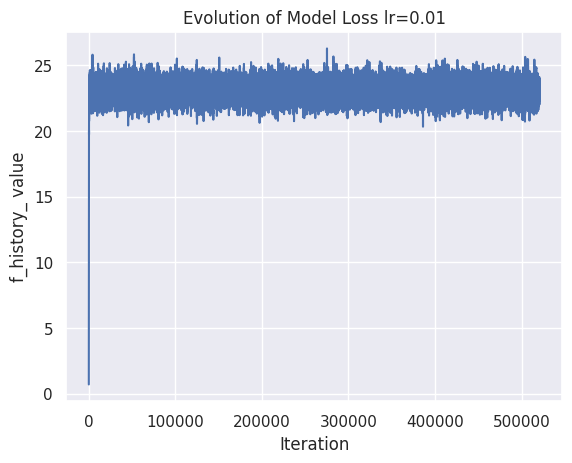

/tmp/ipython-input-709356583.py:223: RuntimeWarning: invalid value encountered in scalar divide
  f1 = 2 * precision * recall / (precision + recall)


model with lr = 0.001
--- Classification Report ---
Threshold: 0.04, Margin: 0.00

Overall Accuracy : 97.14%
Wrong Predictions: 2.86%
Undetermined     : 0.00%
-----------------------------------
Confusion Matrix Rates (as % of Actual)
                   | Pred 1 | Pred -1 | Pred Undet. |
------------------------------------------------------
Actual 1  ( 534 ) | 18.54% | 81.46%  |    0.00%    |
Actual -1 (15884) | 0.22%  | 99.78%  |    0.00%    |
------------------------------------------------------
Precision: 0.7388 | Recall: 0.1854 | F1-Score: 0.2964
-----------------------------------


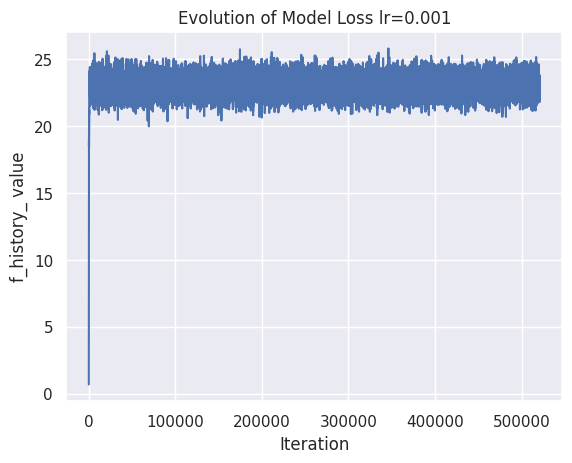

model with lr = 0.1
--- Classification Report ---
Threshold: 0.04, Margin: 0.00

Overall Accuracy : 97.08%
Wrong Predictions: 2.92%
Undetermined     : 0.00%
-----------------------------------
Confusion Matrix Rates (as % of Actual)
                   | Pred 1 | Pred -1 | Pred Undet. |
------------------------------------------------------
Actual 1  ( 534 ) | 27.34% | 72.66%  |    0.00%    |
Actual -1 (15884) | 0.57%  | 99.43%  |    0.00%    |
------------------------------------------------------
Precision: 0.6160 | Recall: 0.2734 | F1-Score: 0.3787
-----------------------------------


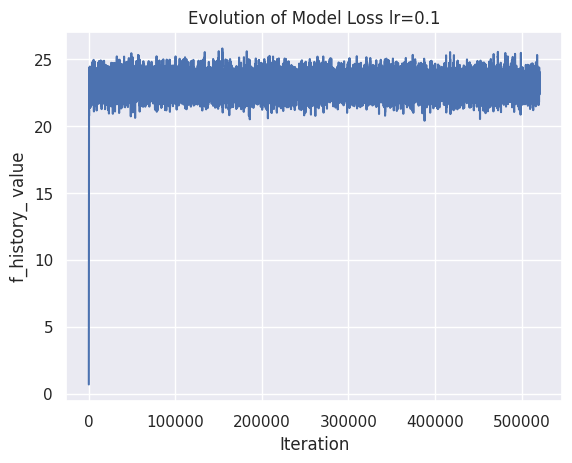

In [ ]:
#TODO
model = StochasticLogisticRegression(thresh = 0.5,lambd=2)
model.fit(X_train,y_train,lr=0.01,bsize=64,max_iter=1000)
thresh,best_f1 = model.find_thresh(X_train,y_train)
print('model with lr = 0.01')
model.accuracy_evaluation(X_test,y_test,thresh = thresh)
plt.figure()
plt.plot(model.f_history_)
plt.title("Evolution of Model Loss lr=0.01")
plt.xlabel("Iteration")
plt.ylabel("f_history_ value")
plt.grid(True)
plt.show()
model = StochasticLogisticRegression(thresh = 0.5,lambd=2)
model.fit(X_train,y_train,lr=0.001,bsize=64,max_iter=1000)
thresh,best_f1 = model.find_thresh(X_train,y_train)
print('model with lr = 0.001')
model.accuracy_evaluation(X_test,y_test,thresh = thresh)
plt.figure()
plt.plot(model.f_history_)
plt.title("Evolution of Model Loss lr=0.001")
plt.xlabel("Iteration")
plt.ylabel("f_history_ value")
plt.grid(True)
plt.show()
model = StochasticLogisticRegression(thresh = 0.5,lambd=2)
model.fit(X_train,y_train,lr=0.1,bsize=64,max_iter=1000)
thresh,best_f1 = model.find_thresh(X_train,y_train)
print('model with lr = 0.1')
model.accuracy_evaluation(X_test,y_test,thresh = thresh)
plt.figure()
plt.plot(model.f_history_)
plt.title("Evolution of Model Loss lr=0.1")
plt.xlabel("Iteration")
plt.ylabel("f_history_ value")
plt.grid(True)
plt.show()





Increasing the learning rate makes the model learn faster by taking larger steps. However, if the steps are too large, the model can overshoot the optimal solution, causing the loss to fluctuate or even increase. This prevents the model from converging to the best possible weights.
Decreasing the learning rate makes the model take tiny steps. This makes the training process more reliable and less likely to overshoot, but it comes at a cost: the model will learn very slowly. It may require a significantly higher number of iterations.

Implement only one acceleration method and compare the results

## Study of the batchsize impact

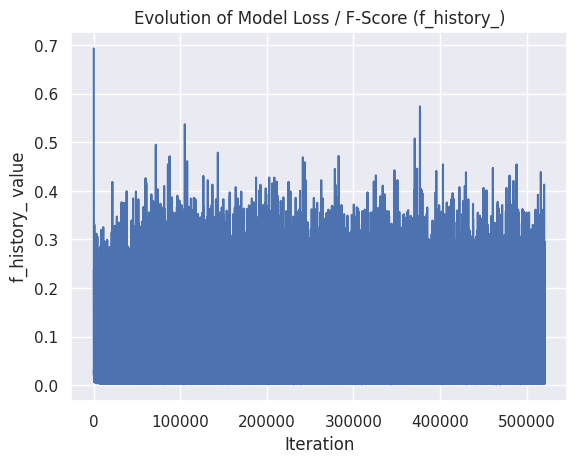

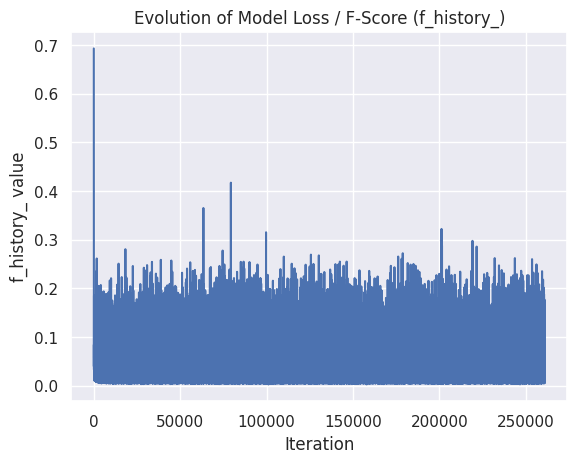

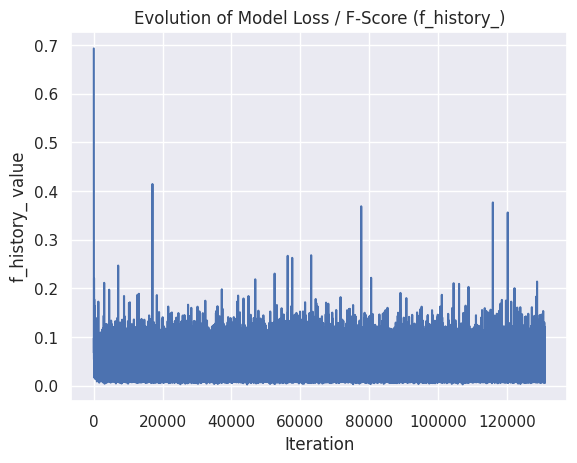

In [ ]:
#TODO : Study the loss
model = StochasticLogisticRegression(thresh = 1,lambd=2)
model.fit(X_train,y_train,lr=0.01,bsize=64,max_iter=1000)
model1 = StochasticLogisticRegression(thresh = 1,lambd=2)
model1.fit(X_train,y_train,lr=0.01,bsize=128,max_iter=1000)
model2 = StochasticLogisticRegression(thresh = 1,lambd=2)
model2.fit(X_train,y_train,lr=0.01,bsize=256,max_iter=1000)


plt.figure()
plt.plot(model.f_history_)
plt.title("Evolution of Model Loss (f_history_) bsize = 64")
plt.xlabel("Iteration")
plt.ylabel("f_history_ value")
plt.grid(True)
plt.show()
plt.figure()
plt.plot(model1.f_history_)
plt.title("Evolution of Model Loss (f_history_) bsize = 128")
plt.xlabel("Iteration")
plt.ylabel("f_history_ value")
plt.grid(True)
plt.show()
plt.figure()
plt.plot(model2.f_history_)
plt.title("Evolution of Model Loss (f_history_) bsize = 256")
plt.xlabel("Iteration")
plt.ylabel("f_history_ value")
plt.grid(True)
plt.show()

Increasing the batch size makes the loss smoother. Indeed, the algorithm computes more accurate values of the gradiant when the batch size is bigger but increasing it too much could lead to unoptimized convergence (the algorithm takes more time to compute the optimal solution because the loss is oversmoothed)

In [ ]:
#TODO : Study the accuracy

model = StochasticLogisticRegression(thresh = 1,lambd=2)
model.fit(X_train,y_train,lr=0.01,bsize=64,max_iter=1000)
thresh,best_f1 = model.find_thresh(X_train,y_train)
print('model with bsize=64')
model.accuracy_evaluation(X_test,y_test,thresh =thresh)
model1 = StochasticLogisticRegression(thresh = 1,lambd=2)
model1.fit(X_train,y_train,lr=0.01,bsize=128,max_iter=1000)
thresh,best_f1 = model1.find_thresh(X_train,y_train)
print('model with bsize=128')
model1.accuracy_evaluation(X_test,y_test,thresh= thresh)
model2 = StochasticLogisticRegression(thresh = 1,lambd=2)
model2.fit(X_train,y_train,lr=0.01,bsize=256,max_iter=1000)
thresh,best_f1 = model2.find_thresh(X_train,y_train)
print('model with bsize=256')
model2.accuracy_evaluation(X_test,y_test,thresh= thresh)



model with bsize=64
--- Classification Report ---
Threshold: 0.03, Margin: 0.00

Overall Accuracy : 82.49%
Wrong Predictions: 17.51%
Undetermined     : 0.00%
-----------------------------------
Confusion Matrix Rates (as % of Actual)
                   | Pred 1 | Pred -1 | Pred Undet. |
------------------------------------------------------
Actual 1  ( 534 ) | 71.72% | 28.28%  |    0.00%    |
Actual -1 (15884) | 17.14% | 82.86%  |    0.00%    |
------------------------------------------------------
Precision: 0.1233 | Recall: 0.7172 | F1-Score: 0.2104
-----------------------------------
model with bsize=128
--- Classification Report ---
Threshold: 0.04, Margin: 0.00

Overall Accuracy : 95.55%
Wrong Predictions: 4.45%
Undetermined     : 0.00%
-----------------------------------
Confusion Matrix Rates (as % of Actual)
                   | Pred 1 | Pred -1 | Pred Undet. |
------------------------------------------------------
Actual 1  ( 534 ) | 61.80% | 38.20%  |    0.00%    |
Actual -1 

{'good_prediction': np.float64(0.966865635278353),
 'wrong_prediction': np.float64(0.03313436472164697),
 'undetermined': np.float64(0.0),
 'TP': np.float64(0.5243445692883895),
 'FN': np.float64(0.4756554307116105),
 'UP': np.float64(0.0),
 'TN': np.float64(0.9817426340972047),
 'FP': np.float64(0.018257365902795267),
 'UN': np.float64(0.0),
 'F1_score': np.float64(0.5072463768115942)}

a big batch size let the model performs well on the training data but poorly on test data (overfitting). This is because the smoother, less noisy gradient updates are more likely to converge to sharp minima.
a small batch size leads to better generalization and higher accuracy on unseen data. The noise introduced by the smaller, more frequent updates helps the model avoid getting stuck in "sharp" local minima

## Gamma impact

model with gamma=0.999
--- Classification Report ---
Threshold: 0.04, Margin: 0.00

Overall Accuracy : 97.10%
Wrong Predictions: 2.90%
Undetermined     : 0.00%
-----------------------------------
Confusion Matrix Rates (as % of Actual)
                   | Pred 1 | Pred -1 | Pred Undet. |
------------------------------------------------------
Actual 1  ( 534 ) | 20.60% | 79.40%  |    0.00%    |
Actual -1 (15884) | 0.33%  | 99.67%  |    0.00%    |
------------------------------------------------------
Precision: 0.6790 | Recall: 0.2060 | F1-Score: 0.3161
-----------------------------------
model with gamma=0.5


/tmp/ipython-input-709356583.py:223: RuntimeWarning: invalid value encountered in scalar divide
  f1 = 2 * precision * recall / (precision + recall)


--- Classification Report ---
Threshold: 0.04, Margin: 0.00

Overall Accuracy : 95.82%
Wrong Predictions: 4.18%
Undetermined     : 0.00%
-----------------------------------
Confusion Matrix Rates (as % of Actual)
                   | Pred 1 | Pred -1 | Pred Undet. |
------------------------------------------------------
Actual 1  ( 534 ) | 61.42% | 38.58%  |    0.00%    |
Actual -1 (15884) | 3.02%  | 96.98%  |    0.00%    |
------------------------------------------------------
Precision: 0.4059 | Recall: 0.6142 | F1-Score: 0.4888
-----------------------------------
model with gamma=0.1
--- Classification Report ---
Threshold: 0.05, Margin: 0.00

Overall Accuracy : 96.78%
Wrong Predictions: 3.22%
Undetermined     : 0.00%
-----------------------------------
Confusion Matrix Rates (as % of Actual)
                   | Pred 1 | Pred -1 | Pred Undet. |
------------------------------------------------------
Actual 1  ( 534 ) | 41.39% | 58.61%  |    0.00%    |
Actual -1 (15884) | 1.35%  | 98

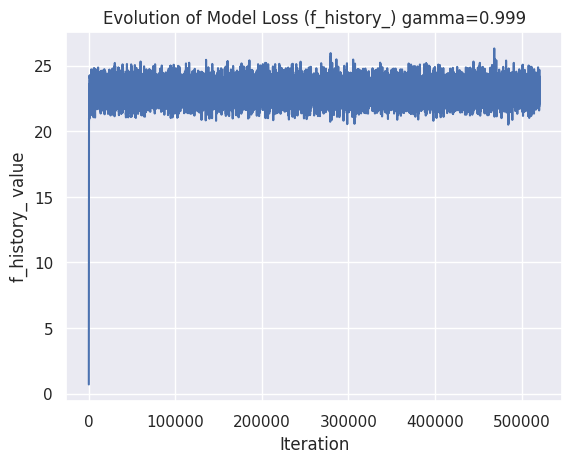

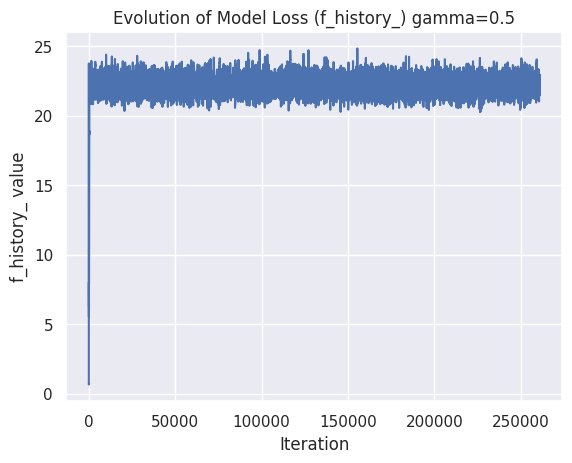

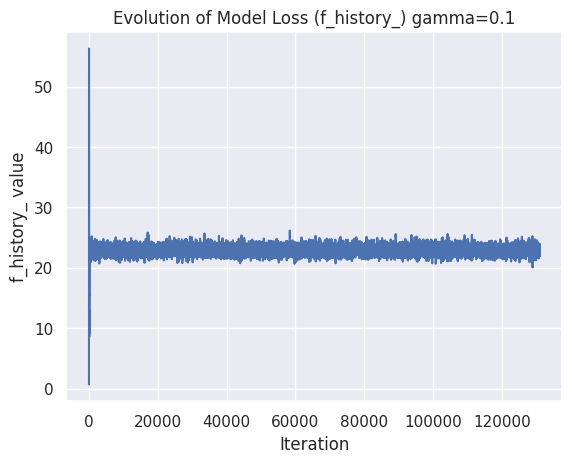

In [ ]:
#TODO : Study Loss and F1-score
model = StochasticLogisticRegression(thresh = 1,lambd=2,gamma=0.999)
model.fit(X_train,y_train,lr=0.01,bsize=64,max_iter=1000)
print('model with gamma=0.999')
thresh,best_f1 = model.find_thresh(X_train,y_train)
model.accuracy_evaluation(X_test,y_test,thresh =thresh)
model1 = StochasticLogisticRegression(thresh = 1,lambd=2,gamma=0.5)
model1.fit(X_train,y_train,lr=0.01,bsize=128,max_iter=1000)
print('model with gamma=0.5')
thresh,best_f1 = model1.find_thresh(X_train,y_train)
model1.accuracy_evaluation(X_test,y_test,thresh =thresh)
model2 = StochasticLogisticRegression(thresh = 1,lambd=2,gamma=0.1)
model2.fit(X_train,y_train,lr=0.01,bsize=256,max_iter=1000)
print('model with gamma=0.1')
thresh,best_f1 = model2.find_thresh(X_train,y_train)
model2.accuracy_evaluation(X_test,y_test,thresh =thresh)

plt.figure()
plt.plot(model.f_history_)
plt.title("Evolution of Model Loss (f_history_) gamma=0.999")
plt.xlabel("Iteration")
plt.ylabel("f_history_ value")
plt.grid(True)
plt.show()
plt.figure()
plt.plot(model1.f_history_)
plt.title("Evolution of Model Loss (f_history_) gamma=0.5")
plt.xlabel("Iteration")
plt.ylabel("f_history_ value")
plt.grid(True)
plt.show()
plt.figure()
plt.plot(model2.f_history_)
plt.title("Evolution of Model Loss (f_history_) gamma=0.1")
plt.xlabel("Iteration")
plt.ylabel("f_history_ value")
plt.grid(True)
plt.show()

for big gamma values, the loss contribution from easy examples is significantly reduced. For instance, if the model predicts a correct class with 95% confidence (for example the class -1 in this case), its contribution to the total loss becomes negligible.
for small gamma values, the loss is calculated more uniformly across all examples, regardless of whether they are easy or hard.

## Beta impact
Nous allons comparer les paramètres beta pour gamma = 0.999 et batch_size=1024

model with beta = 0.9


/tmp/ipython-input-709356583.py:223: RuntimeWarning: invalid value encountered in scalar divide
  f1 = 2 * precision * recall / (precision + recall)


--- Classification Report ---
Threshold: 0.08, Margin: 0.00

Overall Accuracy : 96.97%
Wrong Predictions: 3.03%
Undetermined     : 0.00%
-----------------------------------
Confusion Matrix Rates (as % of Actual)
                   | Pred 1 | Pred -1 | Pred Undet. |
------------------------------------------------------
Actual 1  ( 534 ) | 55.62% | 44.38%  |    0.00%    |
Actual -1 (15884) | 1.64%  | 98.36%  |    0.00%    |
------------------------------------------------------
Precision: 0.5332 | Recall: 0.5562 | F1-Score: 0.5445
-----------------------------------
model with beta = 0.5
--- Classification Report ---
Threshold: 0.09, Margin: 0.00

Overall Accuracy : 97.14%
Wrong Predictions: 2.86%
Undetermined     : 0.00%
-----------------------------------
Confusion Matrix Rates (as % of Actual)
                   | Pred 1 | Pred -1 | Pred Undet. |
------------------------------------------------------
Actual 1  ( 534 ) | 51.12% | 48.88%  |    0.00%    |
Actual -1 (15884) | 1.32%  | 9

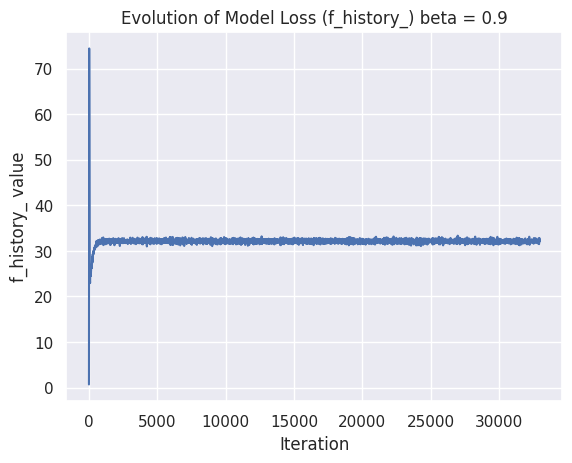

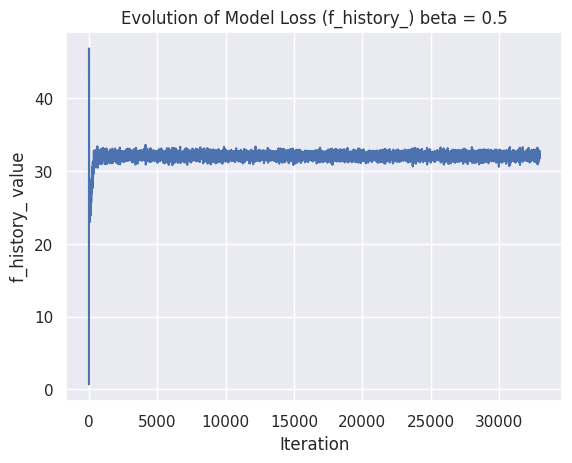

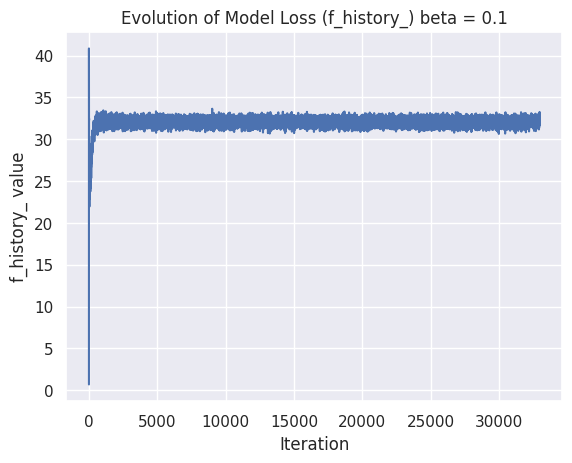

In [ ]:
#TODO : Study Loss and F1-score
model = StochasticLogisticRegression(thresh = 1,lambd=2,gamma=0.999,beta = 0.9)
model.fit(X_train,y_train,lr=0.01,bsize=1024,max_iter=1000)
print('model with beta = 0.9')
thresh,best_f1 = model.find_thresh(X_train,y_train)
model.accuracy_evaluation(X_test,y_test,thresh =thresh)


model1 = StochasticLogisticRegression(thresh = 1,lambd=2,gamma=0.999,beta = 0.5)
model1.fit(X_train,y_train,lr=0.01,bsize=1024,max_iter=1000)
print('model with beta = 0.5')
thresh,best_f1 = model1.find_thresh(X_train,y_train)
model1.accuracy_evaluation(X_test,y_test,thresh =thresh)



model2 = StochasticLogisticRegression(thresh = 1,lambd=2,gamma=0.999,beta = 0.1)
model2.fit(X_train,y_train,lr=0.01,bsize=1024,max_iter=1000)
print('model with beta = 0.1')
thresh,best_f1 = model2.find_thresh(X_train,y_train)
model2.accuracy_evaluation(X_test,y_test,thresh =thresh)



plt.figure()
plt.plot(model.f_history_)
plt.title("Evolution of Model Loss (f_history_) beta = 0.9")
plt.xlabel("Iteration")
plt.ylabel("f_history_ value")
plt.grid(True)
plt.show()
plt.figure()
plt.plot(model1.f_history_)
plt.title("Evolution of Model Loss (f_history_) beta = 0.5")
plt.xlabel("Iteration")
plt.ylabel("f_history_ value")
plt.grid(True)
plt.show()
plt.figure()
plt.plot(model2.f_history_)
plt.title("Evolution of Model Loss (f_history_) beta = 0.1")
plt.xlabel("Iteration")
plt.ylabel("f_history_ value")
plt.grid(True)
plt.show()

Big values of beta makes the training updates more stable and smoother, as they are less affected by sudden, noisy changes in the gradient.
Small values of beta allows the optimizer to adapt very quickly to changes, which can be useful if the loss landscape is changing rapidly.However, it can also lead to more erratic and unstable updates if the gradients are noisy.